In [15]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import dlib
import time
import math

In [16]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
POINTS_NUM_LANDMARK = 68

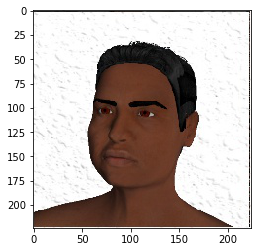

In [17]:
#读取图像
img0 = cv2.imread('man.jpg')
img = img0[:,:,::-1] # 必须为 ::-1
plt.imshow(img) 
plt.show()

In [18]:
# 手动构建7点人脸3D模型
def model_3D():
    '''
    手动构建7点人脸3D模型，以鼻尖为坐标原点
    :return: 3D模型7点矩阵
    '''
    model_points = np.array([
        (-225.0, 170.0, -135.0),  # 左眼左眼角
        (-75.0, 170.0, -135.0),  # 左眼右眼角，自己定的
        (75.0, 170.0, -135.0),  # 右眼左眼角，自己定的
        (225.0, 170.0, -135.0),  # 右眼右眼角
        (0.0, 0.0, 0.0),  # 鼻尖
        (-150.0, -150.0, -125.0),  # 左嘴角
        (150.0, -150.0, -125.0)  # 右嘴角
    ])
    return model_points

In [19]:
# 获取最大的人脸
def largest_face(faces):
    '''
    求最大的人脸
    :param faces:detectors检测到的多个人脸的array
    :return:最大人脸的index
    '''
    if len(faces) == 1:
        return 0
    face_areas = [(face.right() - face.left()) * (face.bottom() - face.top()) for face in faces]  # 求脸的大小
    largest_area = face_areas[0]
    largest_index = 0
    for index in range(1, len(faces)):  # 取最大的脸
        if face_areas[index] > largest_area:
            largest_index = index
            largest_area = face_areas[index]
    print("largest_face index is {} in {} faces".format(largest_index, len(faces)))
    return largest_index

In [20]:
# dlib获取人脸7特征点
def get_landmark7(img):
    '''
    用dlib获取人脸7个特征点
    :param img: 输入图片
    :return: 人脸7特征点矩阵(0, landmark7)，若未检测到人脸，返回(-1，None)
    '''
    faces = detector(img, 0)  # 检测图片中的所有人脸,网上都是1，cvdlib中是0
    if len(faces) == 0:  # 没有检测到人脸
        print("ERROR: found no face")
        return -1, None
    largest_index = largest_face(faces)  # 取最大人脸
    face_rectangle = faces[largest_index]  # 取对应人脸框
    landmark68 = predictor(img, face_rectangle)  # dlib检测人脸特征68点
    landmark7 = np.array([  # 取出68点中所需的7个点
        (landmark68.part(36).x, landmark68.part(36).y),  # 左眼左眼角
        (landmark68.part(39).x, landmark68.part(39).y),  # 左眼右眼角
        (landmark68.part(42).x, landmark68.part(42).y),  # 右眼左眼角
        (landmark68.part(45).x, landmark68.part(45).y),  # 右眼右眼角
        (landmark68.part(30).x, landmark68.part(30).y),  # 鼻尖
        (landmark68.part(48).x, landmark68.part(48).y),  # 左嘴角
        (landmark68.part(54).x, landmark68.part(54).y)  # 右嘴角
    ], dtype="double")
    return 0, landmark7

In [21]:
landmark7=get_landmark7(img)
landmark7[1]

array([[  67.,  104.],
       [  82.,  106.],
       [ 107.,  107.],
       [ 124.,  107.],
       [  83.,  128.],
       [  71.,  150.],
       [ 106.,  154.]])

In [22]:
# 求旋转矩阵和平移矩阵
def get_rot_trans(img_size, landmark7):
    '''
    手动建立人脸3D模型，根据2D人脸特征点求旋转向量和平移向量
    :param img_size:长×宽
    :param landmark7: 2D人脸特征点
    :return: success, rotation_vector, translation_vector, camera_matrix, dist_coeffs
    '''
    # 3D模型
    model_points = model_3D()

    # 相机内参
    focal_length = img_size[1]  # 焦距
    center = (img_size[1] / 2, img_size[0] / 2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]],
         [0, focal_length, center[1]],
         [0, 0, 1]], dtype="double"
    )

    #print("Camera Matrix :{}".format(camera_matrix))
    distortion_coeffs = np.zeros((4, 1))  # 假设没有透镜畸变
    # 透视变换
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, landmark7, camera_matrix,
                                                                  distortion_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)
    #print("Rotation Vector:\n {}".format(rotation_vector))
    #print("Translation Vector:\n {}".format(translation_vector))
    return success, rotation_vector, translation_vector, camera_matrix, distortion_coeffs

In [23]:
success, rotation_vector, translation_vector, camera_matrix, distortion_coeffs=get_rot_trans(img.shape, landmark7[1])

In [24]:
# 从旋转向量转换为欧拉角
def get_euler_angle(rotation_vector):
    '''
    从旋转向量转换为欧拉角
    :param rotation_vector: 旋转向量
    :return: 欧拉角
    '''
    # calculate rotation angles
    theta = cv2.norm(rotation_vector, cv2.NORM_L2)

    # transformed to quaterniond
    w = math.cos(theta / 2)
    x = math.sin(theta / 2) * rotation_vector[0][0] / theta
    y = math.sin(theta / 2) * rotation_vector[1][0] / theta
    z = math.sin(theta / 2) * rotation_vector[2][0] / theta

    ysqr = y * y
    # pitch (x-axis rotation)
    t0 = 2.0 * (w * x + y * z)
    t1 = 1.0 - 2.0 * (x * x + ysqr)
    #print('t0:{}, t1:{}'.format(t0, t1))
    pitch = math.atan2(t0, t1)

    # yaw (y-axis rotation)
    t2 = 2.0 * (w * y - z * x)
    if t2 > 1.0:
        t2 = 1.0
    if t2 < -1.0:
        t2 = -1.0
    yaw = math.asin(t2)

    # roll (z-axis rotation)
    t3 = 2.0 * (w * z + x * y)
    t4 = 1.0 - 2.0 * (ysqr + z * z)
    roll = math.atan2(t3, t4)

    #print('pitch:{}, yaw:{}, roll:{}'.format(pitch, yaw, roll))

    # 单位转换：将弧度转换为度
    Y = int((pitch / math.pi) * 180)
    X = int((yaw / math.pi) * 180)
    Z = int((roll / math.pi) * 180)

    return 0, Y, X, Z

In [25]:
# 计算头部姿势
def pose_estimation(img, img_size):
    '''
    计算头部姿势
    :param img: 输入图片
    :param img_szie: 输入图片大小
    :return: 头部姿势(0, pitch, yaw, roll)
    '''
    try:
        ret, landmark7 = get_landmark7(img)
        if ret != 0:
            print('get_landmark7 failed')
            return -1, None, None, None

        ret, rotation_vector, translation_vector, camera_matrix, dist_coeffs = get_rot_trans(img_size, landmark7)
        if ret != True:
            print('get_pose_estimation failed')
            return -1, None, None, None

        ret, pitch, yaw, roll = get_euler_angle(rotation_vector)
        if ret != 0:
            print('get_euler_angle failed')
            return -1, None, None, None

        euler_angle_str = 'Y:{}, X:{}, Z:{}'.format(pitch, yaw, roll)
        print(euler_angle_str)
        return 0, pitch, yaw, roll

    except Exception as e:
        print('pose_estimation exception:{}'.format(e))
        return -1, None, None, None

In [26]:
ret, pitch, yaw, roll=pose_estimation(img, img.shape)

Y:-134, X:-8, Z:168


In [31]:
# 画表示姿势的线
def draw_line(img,landmark7,rotation_vector,translation_vector, camera_matrix, distortion_coeffs):
    '''
    画表示姿势的线
    :param img: 输入图像
    :param landmark7:2D人脸7个特征点
    :param rotation_vector:旋转向量
    :param translation_vector:平移向量
    :param camera_matrix:相机内参
    :param distortion_coeffs:透镜畸变参数
    :return:
    '''
    (nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]),
                                                     rotation_vector,translation_vector, camera_matrix, distortion_coeffs)
    p1 = (int(landmark7[1][0][0]), int(landmark7[1][0][1]))
    p2 = (int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
    print('p1=',p1)
    print('p2=',p2)
    img = np.copy(img)
    cv2.line(img, p1, p2, (255, 0, 0), 2)
    #img = np.ascontiguousarray(image, dtype=np.uint8)
    # Display image
    # cv2.putText( im, str(rotation_vector), (0, 100), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1 )
    #cv2.putText(img.astype(np.int32), euler_angle_str, (0, 120), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1)
    plt.imshow(img)
    plt.title('Y:{}, X:{}, Z:{}'.format(pitch, yaw, roll))
    plt.show()

p1= (67, 104)
p2= (96, 129)


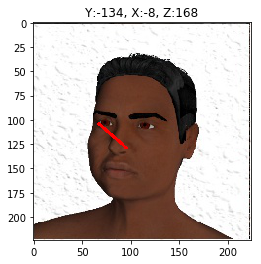

In [32]:
img19 = cv2.imread('man.jpg')
img8 = img19[:,:,::-1] # 必须为 ::-1
draw_line(img8,landmark7,rotation_vector,translation_vector, camera_matrix, distortion_coeffs)

In [ ]:
landmark7= np.array([[  67., 104.],
 [  82., 106.],
 [ 107., 107.],
 [ 124. , 107.],
 [  83. , 128.],
 [  71. , 150.],
 [ 106. , 154.]])

In [ ]:
landmark7[4][0]